# Generated Floor Plan Simulator Demo

This notebook generates a procedural floor plan using BSP and runs the HVAC simulator on it.

In [1]:
#@title Setup
import sys
sys.path.insert(0, '/home/judah/icml/smart_buildings')

import os
import gin
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display

from smart_buildings.smart_control.utils.floor_generator import (
    BSPFloorPlan,
    save_simulation_config,
    display_floor_plan,
    visualize_ahu_zones,
)

from smart_buildings.smart_control.environment import environment, hybrid_action_environment
from smart_buildings.smart_control.proto import smart_control_building_pb2
from smart_buildings.smart_control.proto import smart_control_reward_pb2
from smart_buildings.smart_control.reward import setpoint_energy_carbon_regret
from smart_buildings.smart_control.reward import electricity_energy_cost
from smart_buildings.smart_control.reward import natural_gas_energy_cost
from smart_buildings.smart_control.simulator import building
from smart_buildings.smart_control.simulator import hvac
from smart_buildings.smart_control.simulator import hvac_floorplan_based
from smart_buildings.smart_control.simulator import tf_simulator
from smart_buildings.smart_control.simulator import randomized_arrival_departure_occupancy
from smart_buildings.smart_control.simulator import simulator_building
from smart_buildings.smart_control.utils import building_renderer
from smart_buildings.smart_control.utils import conversion_utils
from smart_buildings.smart_control.utils import observation_normalizer
from smart_buildings.smart_control.utils import environment_utils

2026-02-04 10:45:40.986668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-04 10:45:40.986715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-04 10:45:40.988151: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-04 10:45:40.994918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-04 10:45:41.693027: W tensorflow/compiler/tf2

Generated floor plan: /home/judah/icml/smart_buildings/generated_configs/demo_rectangle_2ahu_floor_plan.npy
Generated zone map: /home/judah/icml/smart_buildings/generated_configs/demo_rectangle_2ahu_zone_map.npy
Generated gin config: /home/judah/icml/smart_buildings/generated_configs/demo_rectangle_2ahu.gin

Building has 19 rooms across 2 AHUs
  AHU 1: 14 rooms
  AHU 2: 5 rooms


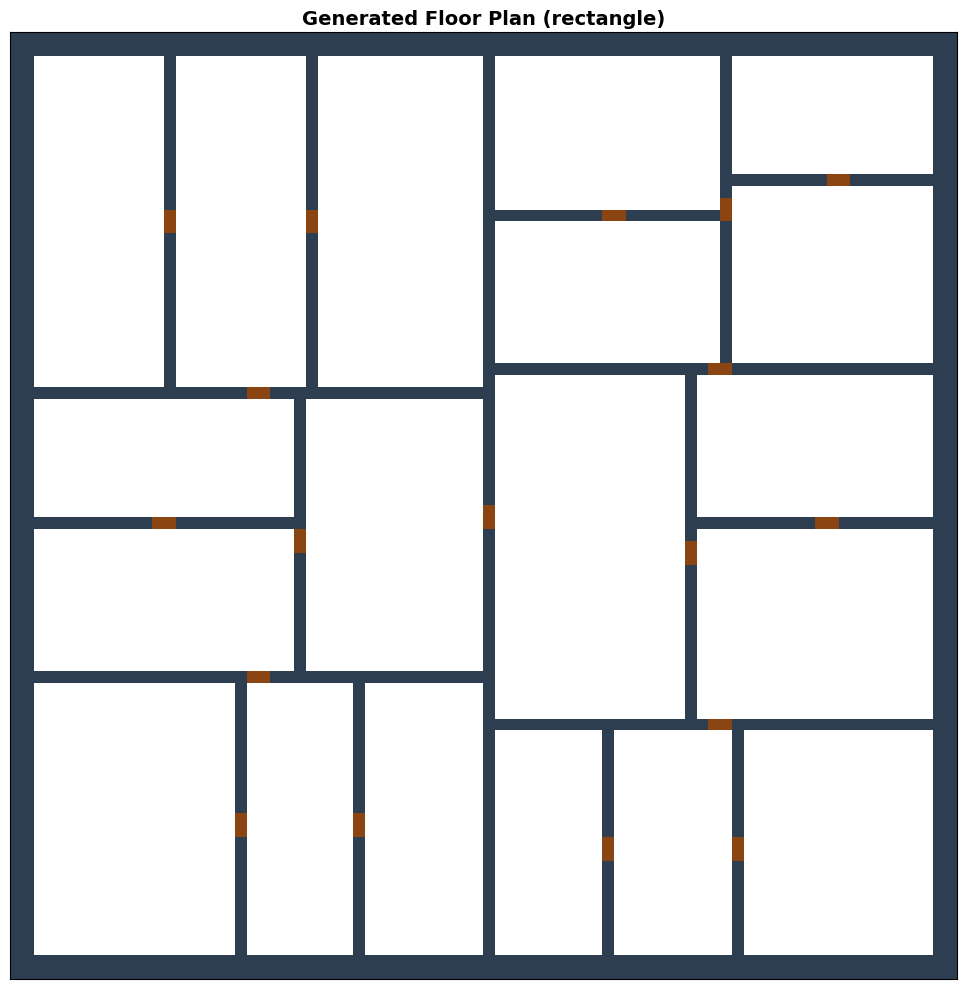

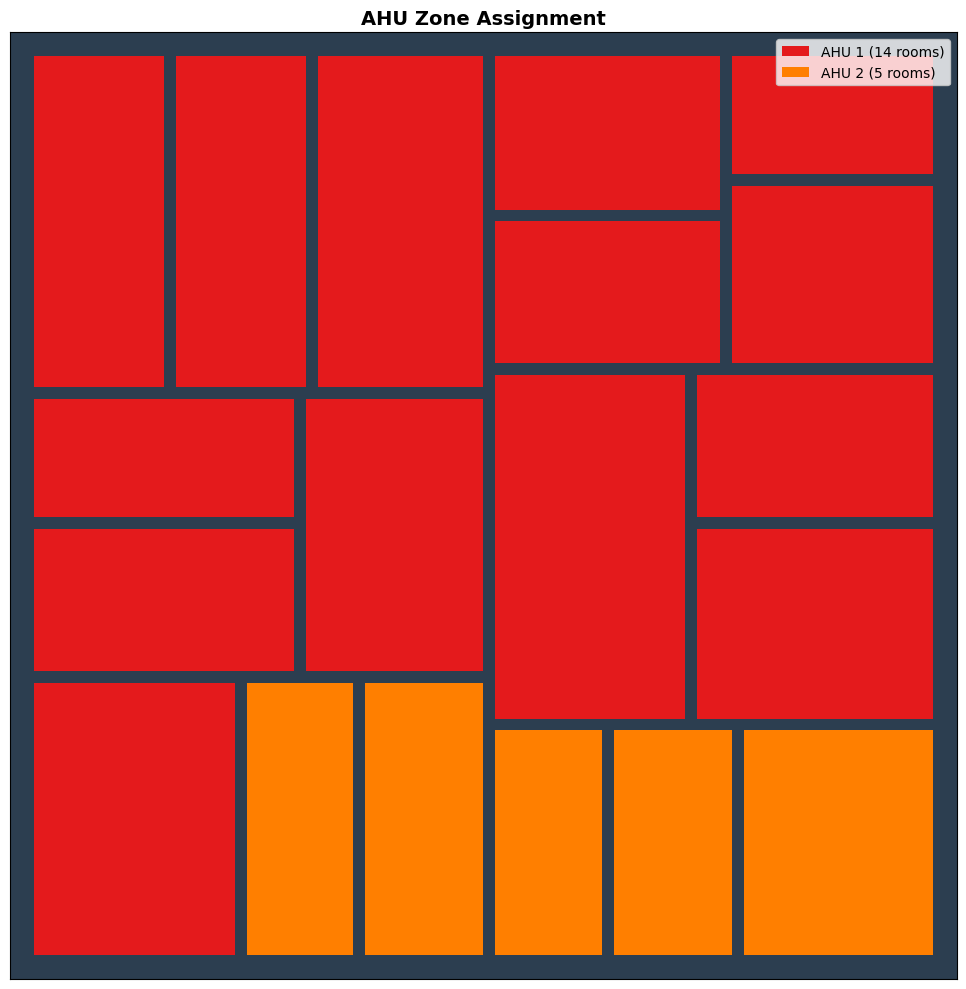

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 2, ..., 2, 1, 1],
       ...,
       [1, 1, 2, ..., 3, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int8)

In [2]:
#@title Generate Floor Plan

# @markdown ### Floor Plan Settings
width = 80  # @param {type:"integer"}
height = 80  # @param {type:"integer"}
min_room_size = 10  # @param {type:"integer"}
wall_thickness = 2  # @param {type:"integer"}
building_shape = "rectangle"  # @param ["rectangle", "trapezoid", "h_shape", "t_shape", "pentagon", "oval", "u_shape", "parallelogram", "semicircle", "triangle"]
num_ahus = 2  # @param {type:"integer"}
seed = 42  # @param {type:"integer"}

# Generate floor plan
bsp = BSPFloorPlan(
    width=width,
    height=height,
    min_room_size=min_room_size,
    wall_thickness=wall_thickness,
    building_shape=building_shape,
)
bsp.generate()

# Save floor plan, zone map, and gin config
output_dir = "/home/judah/icml/smart_buildings/generated_configs"
config_name = f"demo_{building_shape}_{num_ahus}ahu"

result = save_simulation_config(
    bsp,
    output_dir=output_dir,
    num_ahus=num_ahus,
    config_name=config_name,
    seed=seed,
)

print(f"Generated floor plan: {result['floor_plan']}")
print(f"Generated zone map: {result['zone_map']}")
print(f"Generated gin config: {result['gin_config']}")
print(f"\nBuilding has {result['num_rooms']} rooms across {result['num_ahus']} AHUs")

for i, rooms in enumerate(result['assignments'], 1):
    print(f"  AHU {i}: {len(rooms)} rooms")

# Visualize
display_floor_plan(bsp.grid, f"Generated Floor Plan ({building_shape})")
visualize_ahu_zones(bsp, result['assignments'], "AHU Zone Assignment")

In [ ]:
#@title Initialize Environment

# Clear any previous gin config and load the generated one
gin.clear_config()
gin.parse_config_file(result['gin_config'])

# Create environment
env = hybrid_action_environment.HybridActionEnvironment()
env.reset()

print(f"Environment created successfully!")
print(f"Number of rooms: {result['num_rooms']}")
print(f"Number of AHUs: {result['num_ahus']}")

# Show action spec
action_spec = env.action_spec()
print(f"Action spec: {action_spec}")

# Create renderer
building_layout = env.building.simulator.building.floor_plan
renderer = building_renderer.BuildingRenderer(building_layout, 1)

In [ ]:
#@title Simulation Settings

# @markdown ### Viewing Ranges
vmin = 292  # @param {type:"integer"}
vmax = 296  # @param {type:"integer"}

# @markdown ---
# @markdown ### Number of Steps
num_steps = 50  # @param {type:"integer"}

# @markdown ---
# @markdown ### HVAC Actions (Normalized: -1 to 1)

# @markdown **All AHUs**
ahu_run_command = 1  # @param [0, 1] {type:"raw"}
ahu_supply_air_temp = 0.0  # @param {type:"slider", min:-1, max:1, step:0.1}
ahu_static_pressure = 0.0  # @param {type:"slider", min:-1, max:1, step:0.1}

# @markdown **Hot Water System**
hws_run_command = 1  # @param [0, 1] {type:"raw"}
supply_water_setpoint = 0.0  # @param {type:"slider", min:-1, max:1, step:0.1}
differential_pressure = 0.0  # @param {type:"slider", min:-1, max:1, step:0.1}

def render_env(env, vmin, vmax):
    temps = env.building.simulator.building.temp
    image = renderer.render(temps, cmap='bwr', vmin=vmin, vmax=vmax).convert('RGB')
    return image

# Build action based on number of AHUs
discrete_actions = [ahu_run_command] * num_ahus + [hws_run_command]
continuous_actions = []
for _ in range(num_ahus):
    continuous_actions.extend([ahu_supply_air_temp, ahu_static_pressure])
continuous_actions.extend([supply_water_setpoint, differential_pressure])

print(f"Discrete actions ({len(discrete_actions)}): {discrete_actions}")
print(f"Continuous actions ({len(continuous_actions)}): {continuous_actions}")

In [ ]:
#@title Run Simulation

rewards = []
temps_history = []

for step in range(num_steps):
    action = {
        'discrete_action': discrete_actions,
        'continuous_action': continuous_actions,
    }
    
    time_step = env.step(action)
    reward = time_step.reward
    done = time_step.is_last()
    rewards.append(float(reward))
    
    # Get zone temperatures
    vavs = env.building.simulator._hvac._vavs.items()
    temps = [v[1].zone_air_temperature for v in vavs]
    temps_history.append(temps)
    
    if (step + 1) % 10 == 0:
        avg_temp = sum(temps) / len(temps)
        print(f"Step {step + 1}/{num_steps} | Reward: {reward:.4f} | Avg Temp: {avg_temp:.2f}K")
        display(render_env(env, vmin, vmax))
    
    if done:
        print(f"Episode ended at step {step + 1}")
        break

print(f"\nSimulation complete! Total reward: {sum(rewards):.4f}")

In [ ]:
#@title Plot Results

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reward plot
axes[0].plot(rewards, 'b-', linewidth=1.5)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Reward')
axes[0].set_title('Reward Over Time')
axes[0].grid(True, alpha=0.3)

# Temperature plot
temps_array = np.array(temps_history)
avg_temps = temps_array.mean(axis=1)
min_temps = temps_array.min(axis=1)
max_temps = temps_array.max(axis=1)

axes[1].fill_between(range(len(avg_temps)), min_temps, max_temps, alpha=0.3, label='Min/Max')
axes[1].plot(avg_temps, 'r-', linewidth=2, label='Average')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Temperature (K)')
axes[1].set_title('Zone Temperatures Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final average temperature: {avg_temps[-1]:.2f}K ({avg_temps[-1] - 273.15:.2f}C)")